### Парсинг данных и создание датафрейма

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
paths = glob.glob(f"build/*ParticleData_t*.csv")

In [3]:
# Вытаскиваем из первого файла названия столбцов
with open(paths[0], 'r') as f:
    lines = []
    while True:
        line = f.readline()
        if line[0] != '#':
            break
        lines.append(line)
    title = lines[1].replace('#title ', '')[:-1]                        # переделать через regex
    sep = chr(int(lines[2].replace('#separator ', '')[:-1]))            # переделать через regex
    vsc_sep = chr(int(lines[3].replace('#vector_separator ', '')[:-1])) # переделать через regex
    columns = [' '.join(i.split(' ')[2:])[:-1] for i in lines[4:]]
    metarows_len = len(lines)

In [4]:
data = pd.DataFrame()
for path in paths:
    item = pd.read_csv(path, skiprows=metarows_len, names=columns)
    data = data.append(item, ignore_index=True)

In [5]:
data

,particle_name,X,Y,Z,vX,vY,vZ,energy
0,gamma,-2.28945,82.5820,-136.90500,-0.001441,0.029629,-0.047504,0.056006
1,gamma,-122.73100,59.8822,-83.18160,-0.026186,0.012930,-0.018040,0.034326
2,gamma,-82.09540,12.6731,-136.63000,-0.030277,0.005510,-0.048614,0.057536
3,gamma,61.78420,128.7270,71.97290,0.008934,0.018674,0.010544,0.023232
4,gamma,63.44050,116.8560,88.81500,0.009091,0.016438,0.012418,0.022518
...,...,...,...,...,...,...,...,...
1109239,gamma,106.28200,112.4800,-40.25540,0.020046,0.021853,-0.007449,0.030576
1109240,gamma,-143.89300,-20.7735,-66.56750,-0.025442,-0.003796,-0.011912,0.028348
1109241,gamma,-46.85380,-35.4130,-148.72300,-0.024073,-0.017416,-0.072324,0.078190
1109242,gamma,-65.02380,-73.2070,-126.41500,-0.010249,-0.011616,-0.020041,0.025330


In [6]:
set(data["particle_name"])

{'gamma'}

In [7]:
len(data[data["particle_name"]=="e-"])

0

In [8]:
len(data[data["particle_name"]=="gamma"])

1109244

### Отобразим собранные данные

<IPython.core.display.Javascript object>


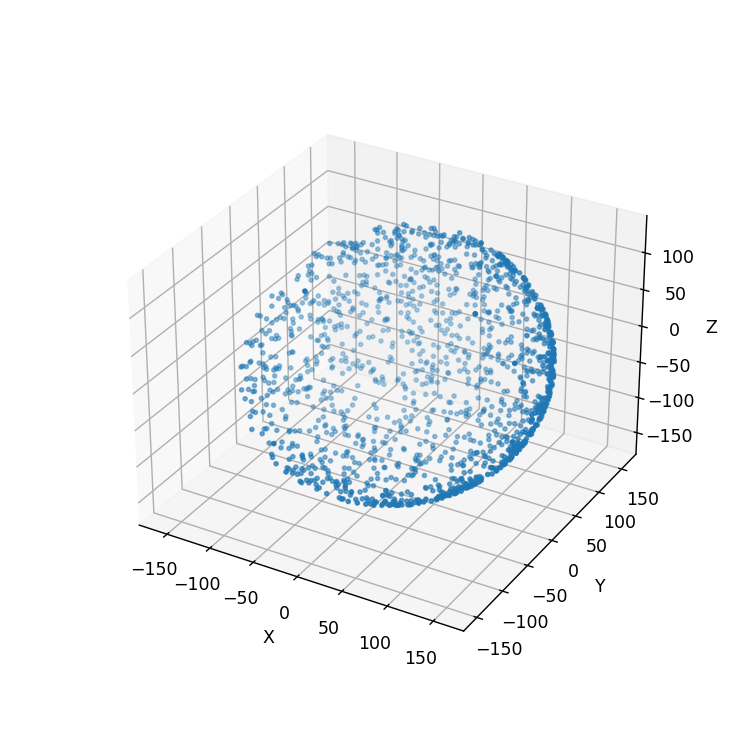

In [9]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[data["particle_name"]=="gamma"]["X"][:1500],
           data[data["particle_name"]=="gamma"]["Y"][:1500],
           data[data["particle_name"]=="gamma"]["Z"][:1500], marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Поворот распределения для более удобной работы

In [10]:
xyz_e = data[data["particle_name"]=="gamma"]
xdata = xyz_e["X"].to_numpy()
ydata = xyz_e["Y"].to_numpy()
zdata = xyz_e["Z"].to_numpy()
xyz = np.array([xdata, ydata, zdata]).T

In [11]:
# Матрица поворота вокруг оси х
ang = -np.pi/4 # 45 градусов
Mx = [[1, 0, 0], [0, np.cos(ang), -np.sin(ang)], [0, np.sin(ang), np.cos(ang)]]

In [12]:
xyz = np.array([np.matmul(point, Mx) for point in xyz])

### Преобразование к полярным координатам

In [13]:
# Я это писал 6 часов, поскольку не думал что формулы из вики или матанализа не работают
def cart2sph(n_xyz: np.array, trh=10**-9):
    ra, θa, φa = [], [], []
    for x, y, z in n_xyz:
        r = np.sqrt(x**2 + y**2 + z**2)
        θ = 0. if np.abs(r) < trh else np.arccos(z/r)
        if x>0 and y>0:
            φ = np.arctan(y/x)
        elif np.abs(x) < trh and y>0:
            φ = np.pi/2
        elif x<0 and y>0:
            φ = np.pi + np.arctan(y/x)
        elif x<0 and y<0:
            φ = np.pi + np.arctan(y/x)
        elif np.abs(x) < trh and y<0:
            φ = np.pi*3/4
        elif x>0 and y<0:
            φ = 2*np.pi + np.arctan(y/x)
        elif np.abs(x) < trh and np.abs(y) < trh:
            φ = 0.
        ra.append(r)
        θa.append(θ)
        φa.append(φ)
    return np.array([ra, θa, φa]).T

def sph2cart(n_rθφ: np.array):
    n_rθφ[:, 2] = n_rθφ[:, 2] % (2*np.pi)
    n_rθφ[:, 1] = n_rθφ[:, 1] % (np.pi)
    x = n_rθφ[:, 0] * np.sin(n_rθφ[:, 1]) * np.cos(n_rθφ[:, 2])
    y = n_rθφ[:, 0] * np.sin(n_rθφ[:, 1]) * np.sin(n_rθφ[:, 2])
    z = n_rθφ[:, 0] * np.cos(n_rθφ[:, 1])
    return np.array([x, y, z]).T

In [14]:
nrθφ = cart2sph(xyz)

In [15]:
print(f"θ range: {min(nrθφ[:,1])} to {max(nrθφ[:,1])}")
print(f"φ range: {min(nrθφ[:,2])} to {max(nrθφ[:,2])}")

θ range: 0.0046224857126805595 to 3.130830162851749
φ range: 0.00020771258009077344 to 6.282560812955008


### Выбор интересующей области

In [16]:
θ_from = np.pi/2-np.pi/10
θ_to = np.pi/2+np.pi/10.

In [17]:
segment, out_segment = [], []
i = 0
j = 0
for r, theta, phi in nrθφ:
    if θ_from<theta and theta<θ_to:
        segment.append((1, theta, phi))
        i += 1
    else:
        out_segment.append((1, theta, phi))
        j += 1
    
xyz_segment = sph2cart(np.array(segment))
xyz_out_segment = sph2cart(np.array(out_segment))

<IPython.core.display.Javascript object>


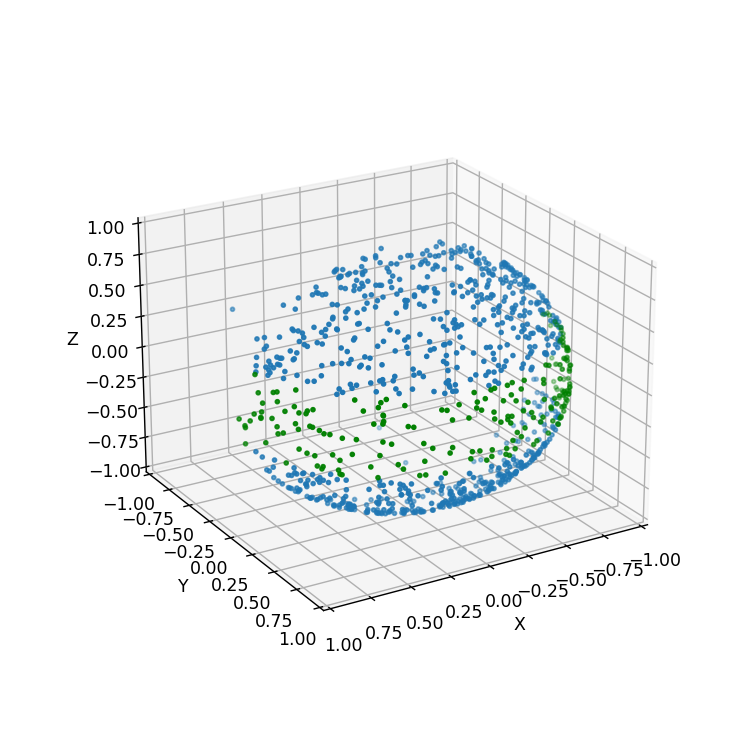

In [18]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*xyz_segment[:200].T, c="green", marker=".")
ax.scatter(*xyz_out_segment[:800].T, marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.show()

In [19]:
segment_theta = np.array(segment).T[2] # Select TPhi
hist = np.histogram(segment_theta, bins=100)
segment_theta.shape

(344541,)

In [20]:
theta = hist[1][:100]
radii = hist[0]

<IPython.core.display.Javascript object>


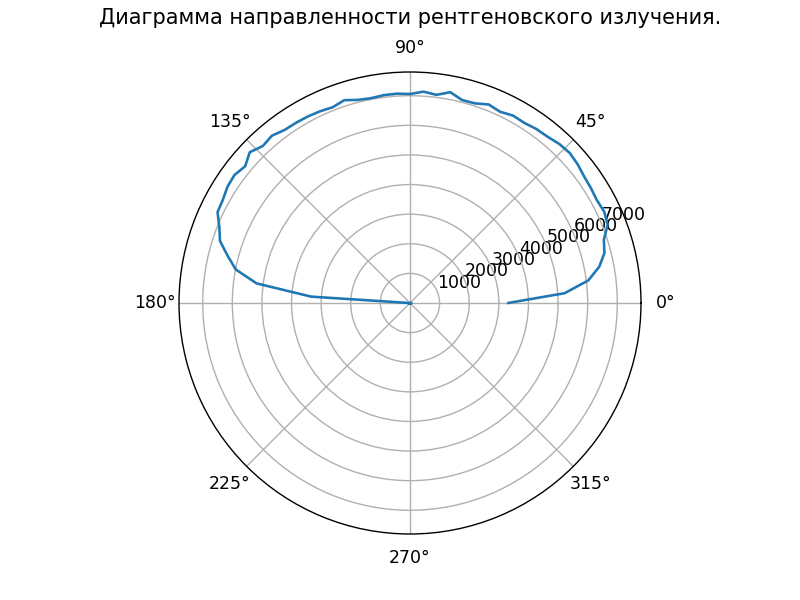

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, radii)
ax.set_title("Диаграмма направленности рентгеновского излучения.", va='bottom')
plt.show()

### Диаграмма по шаровому поясу

In [53]:
xyz_e = data[data["particle_name"]=="gamma"]
xdata = xyz_e["X"].to_numpy()
ydata = xyz_e["Y"].to_numpy()
zdata = xyz_e["Z"].to_numpy()
endata = xyz_e["energy"].to_numpy()
xyz = np.array([xdata, ydata, zdata]).T

In [90]:
ang = -np.pi/2 # 45 градусов
def rotate(nxyz: np.array, axis: str, ang):
    assert nxyz.shape[1] == 3 # shape == (N, 3)
    Mx = [[1, 0, 0], [0, np.cos(ang), -np.sin(ang)], [0, np.sin(ang), np.cos(ang)]]
    My = [[np.cos(ang), 0, np.sin(ang)], [0, 1, 0], [-np.sin(ang), 0, np.cos(ang)]]
    Mz = [[np.cos(ang), -np.sin(ang), 0], [np.sin(ang), np.cos(ang), 0], [0, 0, 1]]
    M = {"X":Mx, "Y":My, "Z":Mz}
    return np.array([np.matmul(point, M[axis]) for point in nxyz])

In [94]:
xyz = rotate(xyz, "X", np.pi)

In [95]:
xyz.shape

(1109244, 3)

<IPython.core.display.Javascript object>


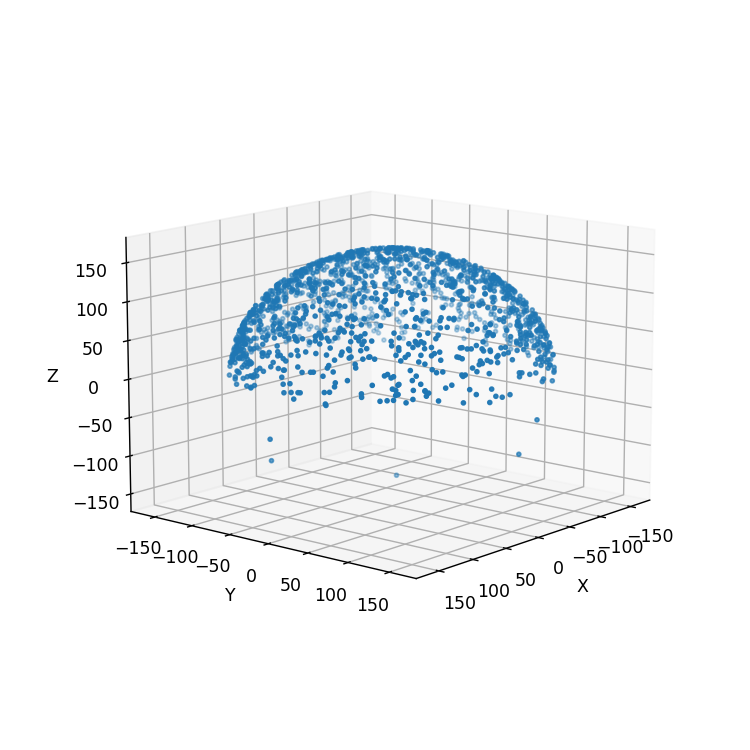

In [96]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:1500,0],
           xyz[:1500,1],
           xyz[:1500,2], marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Подсчёт по кольцам

In [97]:
nrθφ = cart2sph(xyz)

In [ ]:
segments = [], []
dθ = np.pi/12
for r, theta, phi in nrθφ:
    if θ_from<theta and theta<θ_to:
        segment.append((1, theta, phi))
    else:
        out_segment.append((1, theta, phi))

xyz_segment = sph2cart(np.array(segment))
xyz_out_segment = sph2cart(np.array(out_segment))